# Warehouse Optimisation - Last Mile Delivery

In [1]:
# import necessary libraries
import pandas as pd
import numpy as np
import ast
import math
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import to_datetime
import warnings
warnings.filterwarnings('ignore')
from geopy.distance import geodesic
import folium

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score

# User Defined Functions

In [2]:
# function to find nearest warehouse based on warehouse distance

def find_nearest_warehouse(row):
    if pd.isna(row['nearest_warehouse']):
        if round(row['distance_to_nearest_warehouse'], 2) == round(row['distance_to_Thompson'], 2):
            return 'Thompson'
        elif round(row['distance_to_nearest_warehouse'], 2) == round(row['distance_to_Bakers'], 2):
            return 'Bakers'
        elif round(row['distance_to_nearest_warehouse'], 2) == round(row['distance_to_Nickolson'], 2):
            return 'Nickolson'
    return row['nearest_warehouse']

In [3]:
# function to calculate distance between customer co-ordinatess and warehouse co-ordniates for all 3 warehouses

def calculate_dist(customer_data, warehouse_data):
    customer_distances = []
    for _, row in customer_data.iterrows():
        customer_coords = (row['customer_lat'], row['customer_long'])
        distances = {}
        for _, warehouse_row in warehouse_data.iterrows():
            warehouse_coords = (warehouse_row['lat'], warehouse_row['lon'])
            distance = geodesic(customer_coords, warehouse_coords).kilometers
            distances[warehouse_row['names']] = distance
        customer_distances.append((row['customer_id'], row['customer_lat'], row['customer_long'], 
                                   distances['Thompson'], distances['Bakers'], distances['Nickolson']))
    
    # Create a DataFrame with customer information and distances
    columns = ['customer_id', 'customer_lat', 'customer_long', 'distance_to_Thompson', 'distance_to_Bakers', 'distance_to_Nickolson']
    df = pd.DataFrame(customer_distances, columns=columns)
    return df

In [4]:
# to adjust display size of df
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)

# Reading Data

In [5]:
# reading data
xls = pd.ExcelFile(r'C:\Users\gurup\OneDrive\Desktop\Data_last_mile\Data Workbook[76].xlsx')
dirty = pd.read_excel(xls, 'dirty_data')
missing = pd.read_excel(xls, 'Missing Data')
warehouse = pd.read_excel(xls, 'Warehouse Info')

In [6]:
# describe dirty df 

dirty.describe()

,order_price,delivery_charges,customer_lat,customer_long,coupon_discount,order_total,distance_to_nearest_warehouse
count,500.000000,500.000000,500.000000,500.000000,500.000000,5.000000e+02,500.000000
mean,25522.216000,76.658200,-35.835234,144.969494,10.890000,3.920967e+04,2.204224
std,86333.729169,14.481465,12.045393,0.022720,8.649134,2.741940e+05,8.812416
min,585.000000,46.350000,-37.827123,144.924967,0.000000,6.392900e+02,0.107800
25%,7050.000000,65.982500,-37.818222,144.953488,5.000000,6.454735e+03,0.751425
50%,12807.500000,76.310000,-37.812165,144.965357,10.000000,1.129396e+04,1.030100
75%,20360.000000,82.555000,-37.805364,144.983985,15.000000,1.811919e+04,1.408625
max,947691.000000,114.040000,37.826339,145.019837,25.000000,5.688270e+06,94.973400


## Observation:

1. Max value of order_price, order_total & distance_to_nearest_warehouse values are huge. It suggests that data has outliers/inconsistencies.

2. Customer_lat has some +ve values. Looking at the dataset and distance_to_warehouse column, looks like this might be data error.

In [7]:
# df description

missing.describe()

,order_price,delivery_charges,customer_lat,customer_long,coupon_discount,order_total,distance_to_nearest_warehouse,is_happy_customer
count,490.000000,500.000000,490.000000,490.000000,500.000000,490.000000,490.000000,490.000000
mean,13217.867347,77.683380,-37.812597,144.966114,11.190000,11939.841020,1.077335,0.771429
std,7552.951453,14.566667,0.007593,0.021054,8.734213,7032.605471,0.509914,0.420342
min,580.000000,46.200000,-37.828216,144.921217,0.000000,568.640000,0.054900,0.000000
25%,7140.000000,66.975000,-37.818755,144.951541,5.000000,6486.542500,0.723625,1.000000
50%,12180.000000,77.275000,-37.813053,144.963409,10.000000,10756.615000,1.043350,1.000000
75%,18327.500000,85.217500,-37.806714,144.980157,15.000000,16315.555000,1.389525,1.000000
max,37300.000000,110.990000,-37.788265,145.017015,25.000000,37362.470000,3.138800,1.000000


# A)Inspecting Dirty Dataframe

## Performing quality checks on different columns in Dirty Dataset to make sure we have clean data



## 1 - Getting Info

In [8]:
dirty.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   order_id                       500 non-null    object 
 1   customer_id                    500 non-null    object 
 2   date                           500 non-null    object 
 3   nearest_warehouse              500 non-null    object 
 4   shopping_cart                  500 non-null    object 
 5   order_price                    500 non-null    int64  
 6   delivery_charges               500 non-null    float64
 7   customer_lat                   500 non-null    float64
 8   customer_long                  500 non-null    float64
 9   coupon_discount                500 non-null    int64  
 10  order_total                    500 non-null    float64
 11  season                         500 non-null    object 
 12  is_expedited_delivery          500 non-null    boo

## 2. Inspecting nearest_warehouse Column

In [9]:
# inspecting nearest_warehouse column
dirty.nearest_warehouse.value_counts()

Thompson     193
Nickolson    181
Bakers       119
thompson     4  
nickolson    3  
Name: nearest_warehouse, dtype: int64

In [10]:
# replacing bad data with good data
dirty.nearest_warehouse = dirty.nearest_warehouse.replace("thompson","Thompson")
dirty.nearest_warehouse = dirty.nearest_warehouse.replace("nickolson","Nickolson")

## 3. Inspecting Season column

In [11]:
# inspecting season column
dirty.season.value_counts()

Spring    133
Autumn    124
Summer    121
Winter    110
winter    5  
summer    3  
autumn    3  
spring    1  
Name: season, dtype: int64

In [12]:
# replacing bad data with good data
dirty.season = dirty.season.replace("winter","Winter")
dirty.season = dirty.season.replace("autumn","Autumn")
dirty.season = dirty.season.replace("summer","Summer")
dirty.season = dirty.season.replace("spring","Spring")

In [13]:
# converting date column to datetime
dirty['date'] = pd.to_datetime(dirty['date'])

In [14]:
# extracting month
dirty['month'] = dirty['date'].dt.month

In [15]:
# getting unique values of month for each season

In [16]:
summer = dirty[dirty['season']=='Summer']
summer['month'].unique().tolist()

[2, 1, 10, 12, 6, 7, 3, 5, 11, 4]

In [17]:
winter = dirty[dirty['season']=='Winter']
winter['month'].unique().tolist()

[8, 4, 7, 6, 5, 1, 12, 3]

In [18]:
autumn = dirty[dirty['season']=='Autumn']
autumn['month'].unique().tolist()

[5, 4, 3, 1, 11, 12, 9, 10, 2]

In [19]:
spring = dirty[dirty['season']=='Spring']
spring['month'].unique().tolist()

[10, 9, 11, 12, 3, 2]

## Observation

1. Season column is inconsistent with month data. So, i will be using month to populate the correct season values

In [20]:
# correcting season column

In [21]:
summer_months = [2,1,12]
dirty.loc[dirty['month'].isin(summer_months), 'season'] = 'Summer'

In [22]:
winter_months = [6,7,8]
dirty.loc[dirty['month'].isin(winter_months), 'season'] = 'Winter'

In [23]:
autumn_months = [3,5,4]
dirty.loc[dirty['month'].isin(autumn_months), 'season'] = 'Autumn'

In [24]:
spring_months = [9,10,11]
dirty.loc[dirty['month'].isin(spring_months), 'season'] = 'Spring'

In [25]:
check_season = dirty.groupby('season')['month'].value_counts()

print(check_season)

season  month
Autumn  5        45
        4        43
        3        41
Spring  9        51
        10       47
        11       39
Summer  1        48
        2        40
        12       35
Winter  6        40
        8        38
        7        33
Name: month, dtype: int64


## 4. Cleaning 'Cust_lat' column 

In [26]:
# changing dirty customer_lat values
dirty['customer_lat'] = dirty['customer_lat'].apply(lambda x: -x if x > 0 else x)

## 5. Inspecting 'is_expedited_delivery' column

In [27]:
# inspecting is_expedited_delivery column
dirty.is_expedited_delivery.value_counts()

False    251
True     249
Name: is_expedited_delivery, dtype: int64

## 6. inspecting 'is_happy_customer' column

In [28]:
# inspecting is_happy_customer column
dirty.is_happy_customer.value_counts()

True     359
False    141
Name: is_happy_customer, dtype: int64

## 7. Converting 'order_price' to float to match with the given definition

In [29]:
# converting order_price column to float
dirty.order_price = dirty.order_price.astype("float")

## 7.1 Visualizing price columns

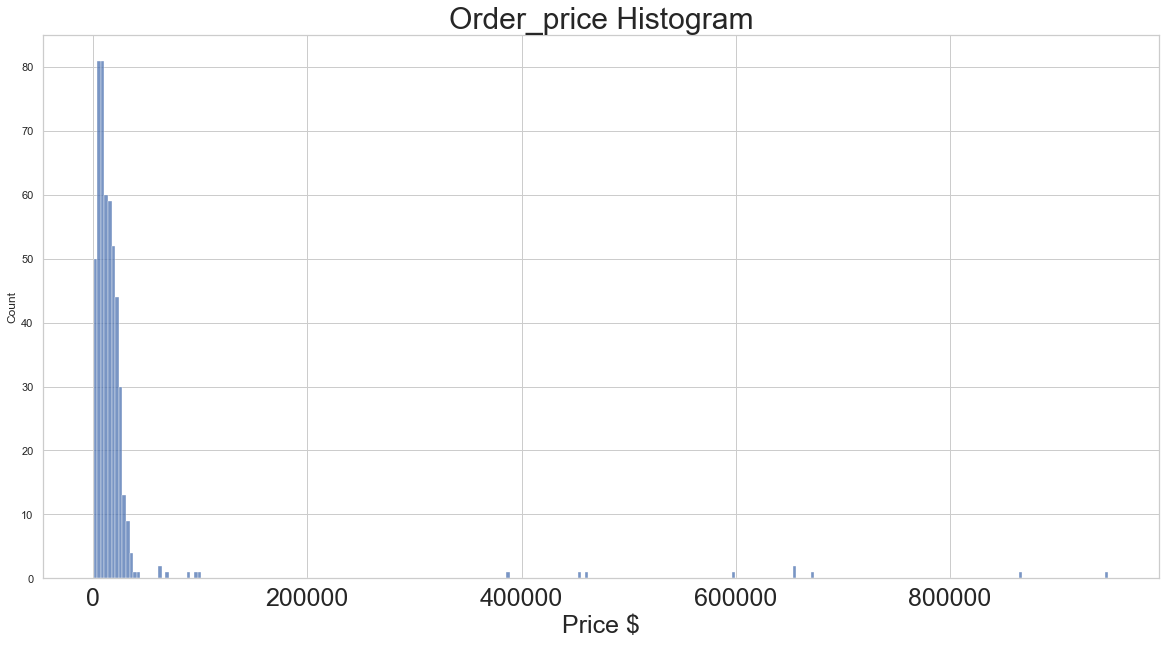

In [30]:
sns.set_theme(style="whitegrid")  # set white grid background
plt.figure(figsize=(20, 10))

# Create a histogram without KDE
sns.histplot(data=dirty, x='order_price', kde=False)

# Formatting ticks size
plt.xticks(fontsize=25)


# Setting title and labels
plt.title("Order_price Histogram", loc='center', fontsize=30)
plt.xlabel('Price $', fontsize=25)

# Show the plot
plt.show()

## 7.2 Draw boxplot to check the presence of outliers

Text(0.5, 0, 'Price $')

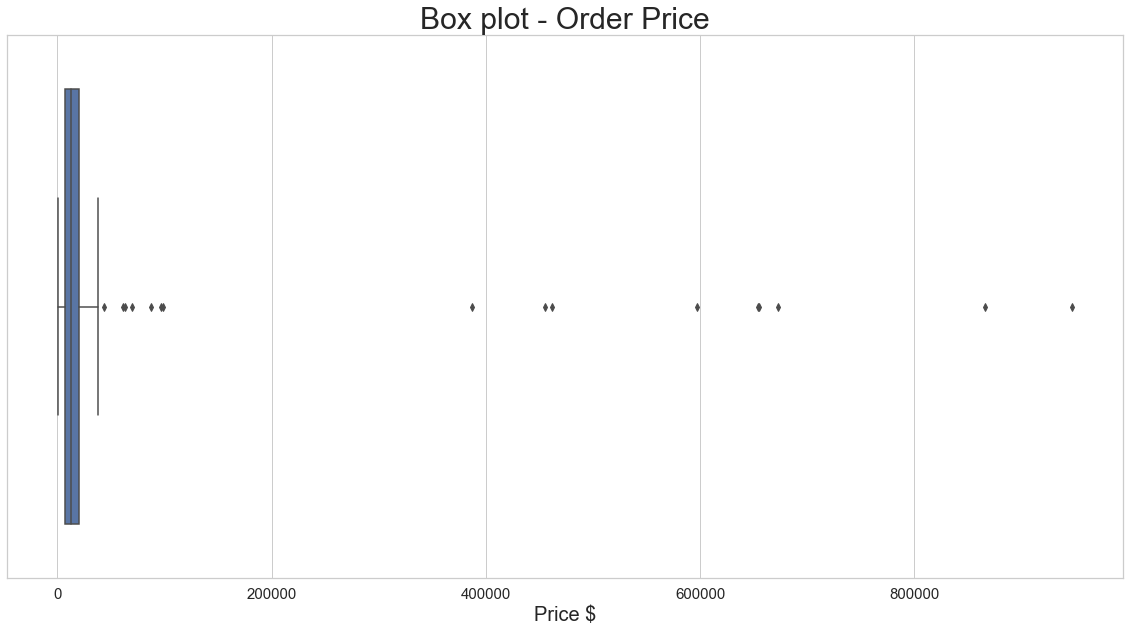

In [31]:

plt.figure(figsize=(20,10))
sns.set_theme(style="whitegrid")
sns.boxplot(x = dirty['order_price'], showfliers=True)

# formatting ticks size
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

# setting lablel and title
plt.title("Box plot - Order Price", loc='center',fontsize=30)
plt.xlabel('Price $',fontsize=20)

## 7.3 Visualizing distance_to_nearest_warehouse column

Text(0.5, 0, 'Distance (Km)')

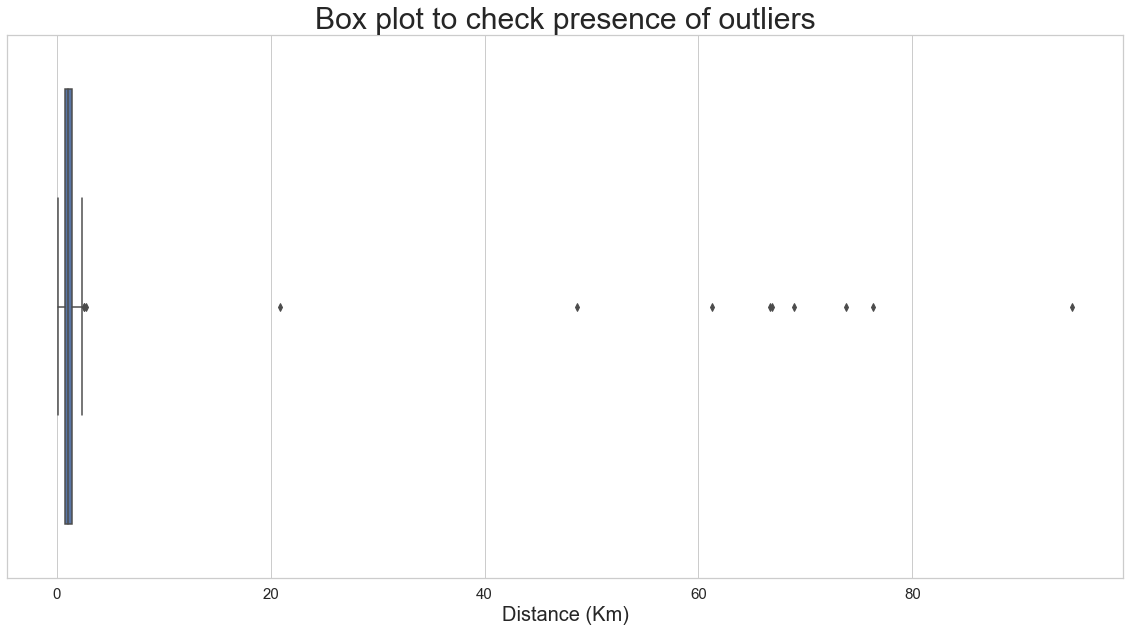

In [32]:
# Draw boxplot to check the presence of outliers
plt.figure(figsize=(20,10))
sns.set_theme(style="whitegrid")
sns.boxplot(x = dirty['distance_to_nearest_warehouse'], showfliers=True)

# formatting ticks size
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

# setting lablel and title
plt.title("Box plot to check presence of outliers", loc='center',fontsize=30)
plt.xlabel('Distance (Km)',fontsize=20)

## 7.4 Visualizing order_total column

Text(0.5, 0, 'order_total ($)')

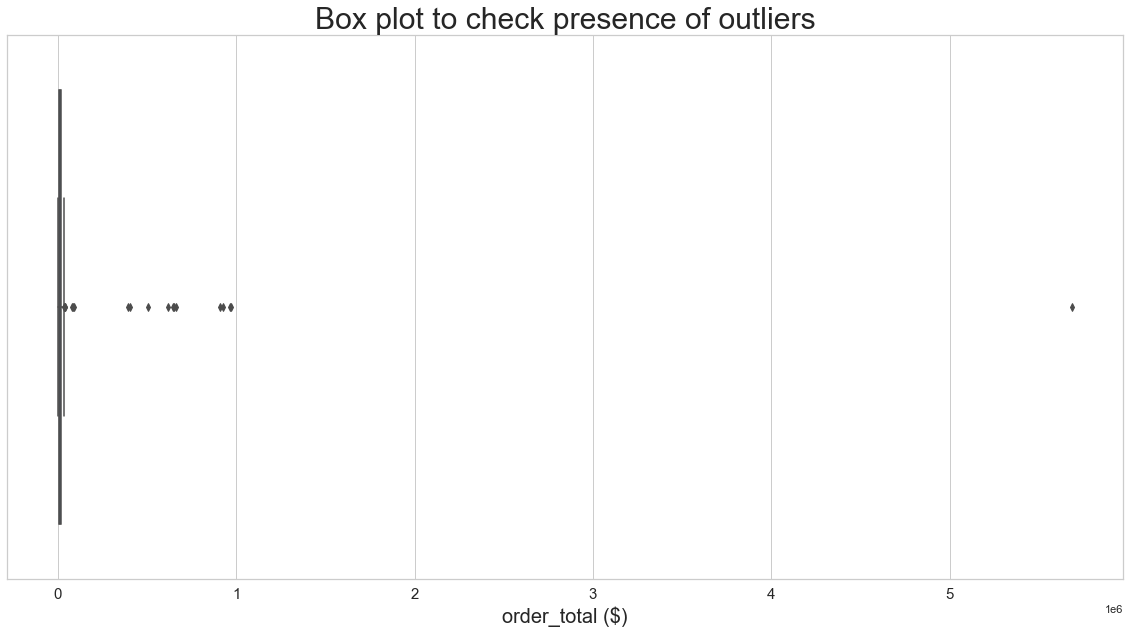

In [33]:
# Draw boxplot to check the presence of outliers
plt.figure(figsize=(20,10))
sns.set_theme(style="whitegrid")
sns.boxplot(x = dirty['order_total'], showfliers=True)

# formatting ticks size
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

# setting lablel and title
plt.title("Box plot to check presence of outliers", loc='center',fontsize=30)
plt.xlabel('order_total ($)',fontsize=20)


## Since we have incorrect data in 'Order_price' & 'Order_total' Columns, I'm using info from dataset to calculate the clean price columns

In [34]:
# Calculate new order_total 
dirty['order_total_calc'] = ((dirty['order_price'] * (1 - dirty['coupon_discount'] / 100)) + dirty['delivery_charges'])

In [35]:
# Calculate new order_price 
dirty['order_price_calc'] = ((dirty['order_total'] - dirty['delivery_charges']) / (1 - (dirty['coupon_discount'] / 100)))

In [36]:
# calculate order_price_ratio
dirty['order_price_ratio'] = dirty['order_price']/dirty['order_total']

In [37]:
# calculate order_total_ratio
dirty['order_total_ratio'] =dirty['order_total']/dirty['order_price']

In [38]:
dirty[dirty['order_total_ratio']>1]

,order_id,customer_id,date,nearest_warehouse,shopping_cart,order_price,delivery_charges,customer_lat,customer_long,coupon_discount,order_total,season,is_expedited_delivery,distance_to_nearest_warehouse,latest_customer_review,is_happy_customer,month,order_total_calc,order_price_calc,order_price_ratio,order_total_ratio
0,ORD010913,ID0361229947,2019-08-26,Bakers,"[('Olivia x460', 1), ('Universe Note', 1), ('Toshika 750', 2), ('Candle Inferno', 2)]",14175.0,55.71,-37.800372,144.975276,0,14230.71,Winter,False,94.9734,one star phone not unblocked.. still have installments payments..,False,8,14230.71,1.417500e+04,0.996085,1.003930
5,ORD496722,ID0589449820,2019-04-09,Nickolson,"[('pearTV', 2), ('iStream', 1), ('Lucent 330S', 1), ('Alcon 10', 2)]",31900.0,79.78,-37.809463,144.972367,0,31979.78,Autumn,True,66.6483,"five stars good speed, like stanley",True,4,31979.78,3.190000e+04,0.997505,1.002501
9,ORD067226,ID0580161464,2019-10-10,Thompson,"[('Toshika 750', 1), ('Lucent 330S', 2), ('Thunder line', 2), ('Candle Inferno', 1)]",11570.0,91.79,-37.789119,144.938062,0,11661.79,Spring,False,2.7391,"whatta deal good as new, works with verizon.",True,10,11661.79,1.157000e+04,0.992129,1.007933
10,ORD026682,ID0076459536,2019-04-26,Bakers,"[('iStream', 1), ('Thunder line', 2), ('Candle Inferno', 2), ('Lucent 330S', 2)]",7830.0,70.74,-37.791144,144.936863,0,7900.74,Autumn,True,2.5592,defectuoso defectuoso,False,4,7900.74,7.830000e+03,0.991046,1.009034
15,ORD083728,ID0746908734,2019-10-25,Bakers,"[('Toshika 750', 2), ('Olivia x460', 1)]",9865.0,112.04,-37.821844,145.015337,0,9977.04,Spring,True,2.2057,"not what i expected i didnâ€™t like the clarity, and i used it because i was traveling internationally",True,10,9977.04,9.865000e+03,0.988770,1.011357
21,ORD234302,ID0746909188,2019-11-03,Bakers,"[('Olivia x460', 1), ('Toshika 750', 2), ('iStream', 1)]",10015.0,97.76,-37.820343,145.014446,0,10112.76,Spring,True,2.0449,volume is a problem we have to take off the protective case for it to sound clear.,False,11,10112.76,1.001500e+04,0.990333,1.009761
26,ORD244594,ID0361268957,2019-09-26,Bakers,"[('pearTV', 2), ('Universe Note', 2), ('Thunder line', 1), ('Candle Inferno', 1)]",22130.0,108.92,-37.798997,144.977882,25,649193.76,Spring,True,1.9565,love this tablet easy to use and extremely affordable,True,9,16706.42,8.654465e+05,0.034088,29.335461
27,ORD490527,ID1492169258,2019-10-16,Thompson,"[('Candle Inferno', 1), ('Alcon 10', 1), ('iStream', 2), ('Universe Note', 2)]",16580.0,110.36,-37.801083,144.963781,0,16690.36,Spring,True,1.9558,five stars pretty,True,10,16690.36,1.658000e+04,0.993388,1.006656
28,ORD089655,ID5096779239,2019-01-16,Nickolson,"[('Universe Note', 2), ('iStream', 1), ('Olivia x460', 2), ('Toshika 750', 1)]",13820.0,105.47,-37.801202,144.969929,0,13925.47,Summer,True,1.9364,exceeds the expectations love the picture the quality and the sound effect,True,1,13925.47,1.382000e+04,0.992426,1.007632
29,ORD273727,ID0581750598,2019-03-16,Thompson,"[('Universe Note', 2), ('Olivia x460', 1), ('Thunder line', 2), ('pearTV', 2)]",25105.0,81.70,-37.804201,144.927966,0,25186.70,Autumn,True,1.9267,great condition works like new,True,3,25186.70,2.510500e+04,0.996756,1.003254


In [39]:
dirty[dirty['order_price_ratio']>1]

,order_id,customer_id,date,nearest_warehouse,shopping_cart,order_price,delivery_charges,customer_lat,customer_long,coupon_discount,order_total,season,is_expedited_delivery,distance_to_nearest_warehouse,latest_customer_review,is_happy_customer,month,order_total_calc,order_price_calc,order_price_ratio,order_total_ratio
1,ORD353238,ID0214092261,2019-05-30,Bakers,"[('Universe Note', 1), ('iAssist Line', 2), ('Lucent 330S', 2), ('Olivia x460', 2)]",12810.0,84.86,-37.809083,145.011628,10,11613.86,Autumn,True,76.3419,"5 stars for a note 5 super good, minor wear, though broken s pen, easily fixed with super glue. lovely phone overall, though",True,5,11613.86,12810.000000,1.102992,0.906625
2,ORD420507,ID0777791299,2019-04-15,Thompson,"[('Candle Inferno', 1), ('Alcon 10', 1), ('pearTV', 2)]",22000.0,63.58,-37.808332,144.954755,5,20963.58,Autumn,False,73.8324,great mid-range daily driver! amazing phone for the price. build quality is impeccable. only reason i deducted a star was because it didn't support 5ghz wifi. really disappointed for a phone that came out in 2017.,True,4,20963.58,22000.000000,1.049439,0.952890
3,ORD322017,ID0591429491,2019-03-21,Nickolson,"[('Toshika 750', 2), ('Candle Inferno', 1), ('Alcon 10', 1), ('Lucent 330S', 1)]",19250.0,48.55,-37.818227,144.965114,10,17373.55,Autumn,False,68.8892,one star was sent completely non functioning phone. microphone does not work.,False,3,17373.55,19250.000000,1.108006,0.902522
4,ORD289920,ID0702374154,2019-02-14,Thompson,"[('Thunder line', 1), ('iStream', 2)]",2480.0,72.41,-37.807499,144.942120,25,1932.41,Summer,False,66.8512,i like that it respond most of my comands. great product.,True,2,1932.41,2480.000000,1.283372,0.779198
6,ORD232940,ID2020835025,2019-01-04,Nickolson,"[('iAssist Line', 1), ('Toshika 750', 1)]",6545.0,77.11,-37.814917,144.968020,5,6294.86,Summer,True,61.2935,tablet had trouble from the begging it kept restarting and rebooting i had to return it.,False,1,6294.86,6545.000000,1.039737,0.961782
7,ORD205507,ID2143829886,2019-05-06,Thompson,"[('Lucent 330S', 1), ('Toshika 750', 2), ('Universe Note', 2)]",16770.0,81.95,-37.802420,144.934978,5,16013.45,Autumn,True,48.5984,the only thing i don't like is it freezes up n i have to restart ... the only thing i don't like is it freezes up n i have to restart it but other than that i love it,True,5,16013.45,16770.000000,1.047245,0.954887
8,ORD314525,ID0361770819,2019-02-20,Bakers,"[('Lucent 330S', 1), ('iStream', 1)]",1380.0,67.79,-37.800469,144.980759,25,1102.79,Summer,False,20.8952,one star waste of money,False,2,1102.79,1380.000000,1.251372,0.799123
11,ORD256016,ID0052450483,2019-08-27,Thompson,"[('Lucent 330S', 1), ('Olivia x460', 2), ('Alcon 10', 2)]",21580.0,74.21,-37.791485,144.936760,15,18417.21,Winter,False,2.5269,five stars perfect,True,8,18417.21,21580.000000,1.171730,0.853439
12,ORD094945,ID4353884085,2019-03-16,Bakers,"[('Alcon 10', 2), ('Toshika 750', 1), ('Lucent 330S', 1), ('Thunder line', 2)]",27810.0,71.66,-37.825402,145.014204,15,23710.16,Autumn,True,2.3926,"and what they sent me is a crap - i can't make calls it was a mistake to purchase this cell phone. do not buy this product. the first divice was replaced due to the microphone issues after 2 month of use. and what they sent me is a crap - i can't make calls, send text messages, applications are not working, the screen is not responding.",False,3,23710.16,27810.000000,1.172915,0.852577
13,ORD215329,ID0580186550,2019-04-14,Thompson,"[('pearTV', 1), ('iStream', 2), ('Universe Note', 2), ('Alcon 10', 1)]",22460.0,70.09,-37.799883,144.927270,15,19161.09,Autumn,False,2.2493,"looks good! was a gift for daughter. she's happy with, said she likes the look and feel.",True,4,19161.09,22460.000000,1.172167,0.853121


In [40]:
#filter values to be changed
ot_mask = (dirty['order_total_ratio'] > 1) & (dirty['order_total'] != dirty['order_total_calc'])

# Update the 'order_total' 
dirty.loc[ot_mask, 'order_total'] = dirty.loc[ot_mask, 'order_total_calc']

In [41]:
#filter values to be changed
op_mask = (dirty['order_price_ratio'] > 1) & (dirty['order_price'] != dirty['order_price_calc'] )

# Update 'order_price' 
dirty.loc[op_mask, 'order_price'] = dirty.loc[op_mask, 'order_price_calc']

## 8. Inspecting Order_id & Customer_id

In [42]:
# Define a common pattern for order IDs 
order_pattern = 'ORD\d+'

# Identify anomalies based on a different pattern
order_id_anomalies = dirty[~dirty['order_id'].str.match(order_pattern)]

print(order_id_anomalies)

Empty DataFrame
Columns: [order_id, customer_id, date, nearest_warehouse, shopping_cart, order_price, delivery_charges, customer_lat, customer_long, coupon_discount, order_total, season, is_expedited_delivery, distance_to_nearest_warehouse, latest_customer_review, is_happy_customer, month, order_total_calc, order_price_calc, order_price_ratio, order_total_ratio]
Index: []


In [43]:
# Define a common pattern for customer_id
customer_pattern = 'ID\d+'

# Identify anomalies based on a different pattern
customer_id_anomalies = dirty[~dirty['customer_id'].str.match(customer_pattern)]

print(customer_id_anomalies)

Empty DataFrame
Columns: [order_id, customer_id, date, nearest_warehouse, shopping_cart, order_price, delivery_charges, customer_lat, customer_long, coupon_discount, order_total, season, is_expedited_delivery, distance_to_nearest_warehouse, latest_customer_review, is_happy_customer, month, order_total_calc, order_price_calc, order_price_ratio, order_total_ratio]
Index: []


In [44]:
dirty_df_copy = dirty

In [45]:
# dropping extra columns
dirty.drop(columns=['order_total_calc','order_price_calc','order_price_ratio','order_total_ratio'], inplace=True)

In [46]:
dirty.describe()

,order_price,delivery_charges,customer_lat,customer_long,coupon_discount,order_total,distance_to_nearest_warehouse,month
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.00000,500.000000,500.000000
mean,13683.588024,76.658200,-37.801550,144.969494,10.890000,12287.16542,2.204224,6.402000
std,8135.466542,14.481465,0.090369,0.022720,8.649134,7429.58944,8.812416,3.460686
min,585.000000,46.350000,-37.827123,144.924967,0.000000,530.54000,0.107800,1.000000
25%,7020.000000,65.982500,-37.818399,144.953488,5.000000,6267.48250,0.751425,3.000000
50%,12727.500000,76.310000,-37.812503,144.965357,10.000000,11067.89500,1.030100,6.000000
75%,19710.000000,82.555000,-37.806106,144.983985,15.000000,17616.37000,1.408625,9.000000
max,43520.000000,114.040000,-37.020195,145.019837,25.000000,41406.93000,94.973400,12.000000


In [47]:
dirty.shape

(500, 17)

# B) Inspecting Missing DF

In [48]:
missing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       500 non-null    object        
 1   customer_id                    500 non-null    object        
 2   date                           500 non-null    datetime64[ns]
 3   nearest_warehouse              490 non-null    object        
 4   shopping_cart                  500 non-null    object        
 5   order_price                    490 non-null    float64       
 6   delivery_charges               500 non-null    float64       
 7   customer_lat                   490 non-null    float64       
 8   customer_long                  490 non-null    float64       
 9   coupon_discount                500 non-null    int64         
 10  order_total                    490 non-null    float64       
 11  season             

## 1. Inspecting categorical columns

In [49]:
# inspecting nearest_warehouse
missing.nearest_warehouse.value_counts()

Thompson     208
Nickolson    177
Bakers       105
Name: nearest_warehouse, dtype: int64

In [50]:
# inspecting season
missing.season.value_counts()

Spring    131
Winter    122
Summer    122
Autumn    115
Name: season, dtype: int64

In [51]:
# extracting month
missing['month'] = missing['date'].dt.month

In [52]:
# getting unique months for season

In [53]:
summer = missing[missing['season']=='Summer']
summer['month'].unique().tolist()

[1, 2, 12]

In [54]:
winter = missing[missing['season']=='Winter']
winter['month'].unique().tolist()

[6, 7, 8]

In [55]:
autumn = missing[missing['season']=='Autumn']
autumn['month'].unique().tolist()

[3, 5, 4]

In [56]:
spring = missing[missing['season']=='Spring']
spring['month'].unique().tolist()

[9, 10, 11]

## 2. Converting 'is_happy_customer'

In [57]:
#converting column to boolean
missing['is_happy_customer'] = missing['is_happy_customer'] == 1.0

## 3. 'customer_lat' & 'customer_long' columns have null values which are not ideal for our analysis. So we will be dropping them

In [58]:
missing = missing.dropna(subset=['customer_lat', 'customer_long','is_happy_customer'])

In [59]:
missing.shape

(480, 17)

## 4. Filling Null values in 'nearest_warehouse' column using UDF

In [60]:
missing['nearest_warehouse'] = missing['nearest_warehouse'].astype(str)

In [61]:
# Apply the custom function to populate null values in 'nearest_warehouse' column
missing['nearest_warehouse'] = missing.apply(find_nearest_warehouse, axis=1)

In [62]:
missing['nearest_warehouse'].isnull().sum()

0

## 5. Filling null values in 'order_price' & 'order_total' column

In [63]:
# Calculate order_total 
missing['order_total_calc'] = ((missing['order_price'] * (1 - missing['coupon_discount'] / 100)) + missing['delivery_charges'])

In [64]:
# Calculate order_price
missing['order_price_calc'] = ((missing['order_total'] - missing['delivery_charges']) / (1 - (missing['coupon_discount'] / 100)))

In [65]:
# filter null values
ot_mask = missing['order_total'].isnull() 

# update  order_total
missing['order_total'] = np.where(ot_mask, missing['order_total_calc'], missing['order_total'])

In [66]:
#filter null values
op_mask = missing['order_price'].isnull() 

# update  order_price
missing['order_price'] = np.where(op_mask, missing['order_price_calc'], missing['order_price'])

## 6. Inspecting 'season' column

In [67]:
summer_months = [2,1,12]
missing.loc[missing['month'].isin(summer_months), 'season'] = 'Summer'

In [68]:
winter_months = [6,7,8]
missing.loc[missing['month'].isin(winter_months), 'season'] = 'Winter'

In [69]:
autumn_months = [3,5,4]
missing.loc[missing['month'].isin(autumn_months), 'season'] = 'Autumn'

In [70]:
spring_months = [9,10,11]
missing.loc[missing['month'].isin(spring_months), 'season'] = 'Spring'

In [71]:
# dropping extra columns
missing.drop(columns=['order_total_calc','order_price_calc'], inplace=True)

In [72]:
missing.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 480 entries, 0 to 499
Data columns (total 17 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       480 non-null    object        
 1   customer_id                    480 non-null    object        
 2   date                           480 non-null    datetime64[ns]
 3   nearest_warehouse              480 non-null    object        
 4   shopping_cart                  480 non-null    object        
 5   order_price                    480 non-null    float64       
 6   delivery_charges               480 non-null    float64       
 7   customer_lat                   480 non-null    float64       
 8   customer_long                  480 non-null    float64       
 9   coupon_discount                480 non-null    int64         
 10  order_total                    480 non-null    float64       
 11  season             

In [73]:
missing.shape

(480, 17)

#  C)Data Preparation

## Merging the 2 cleaned dataframes for further analysis

In [74]:
union_df = pd.concat([dirty, missing], ignore_index=True)

In [75]:
union_df.shape

(980, 17)

## Calling UDF function to calculate warehouse distances

In [76]:
customer_data = union_df[['customer_id','customer_lat','customer_long']]
warehouse_data = warehouse

cust_dist_df = calculate_dist(customer_data, warehouse_data)

In [77]:
cust_dist_df.shape

(980, 6)

In [78]:
cust_dist_df.describe()

,customer_lat,customer_long,distance_to_Thompson,distance_to_Bakers,distance_to_Nickolson
count,980.000000,980.000000,980.000000,980.000000,980.000000
mean,-37.806936,144.967852,2.909826,3.488411,2.552000
std,0.064970,0.021952,7.142423,7.034519,7.135128
min,-37.828216,144.924967,0.077533,0.054950,0.070824
25%,-37.818511,144.952312,1.224752,1.883875,1.121368
50%,-37.812703,144.964120,1.845082,2.815980,1.872819
75%,-37.806317,144.982191,3.259325,3.919496,2.644741
max,-37.020195,145.019837,87.965366,87.701794,88.612514


In [79]:
# concatenate distance columns to dataframe
data_df = pd.concat([union_df, cust_dist_df[['distance_to_Thompson','distance_to_Bakers','distance_to_Nickolson']]], axis=1)

In [80]:
data_df[data_df['distance_to_nearest_warehouse'] > 5]

,order_id,customer_id,date,nearest_warehouse,shopping_cart,order_price,delivery_charges,customer_lat,customer_long,coupon_discount,order_total,season,is_expedited_delivery,distance_to_nearest_warehouse,latest_customer_review,is_happy_customer,month,distance_to_Thompson,distance_to_Bakers,distance_to_Nickolson
0,ORD010913,ID0361229947,2019-08-26,Bakers,"[('Olivia x460', 1), ('Universe Note', 1), ('Toshika 750', 2), ('Candle Inferno', 2)]",14175.0,55.71,-37.800372,144.975276,0,14230.71,Winter,False,94.9734,one star phone not unblocked.. still have installments payments..,False,8,2.834529,2.056572,2.084522
1,ORD353238,ID0214092261,2019-05-30,Bakers,"[('Universe Note', 1), ('iAssist Line', 2), ('Lucent 330S', 2), ('Olivia x460', 2)]",12810.0,84.86,-37.809083,145.011628,10,11613.86,Autumn,True,76.3419,"5 stars for a note 5 super good, minor wear, though broken s pen, easily fixed with super glue. lovely phone overall, though",True,5,5.698889,1.447394,3.852552
2,ORD420507,ID0777791299,2019-04-15,Thompson,"[('Candle Inferno', 1), ('Alcon 10', 1), ('pearTV', 2)]",22000.0,63.58,-37.808332,144.954755,5,20963.58,Autumn,False,73.8324,great mid-range daily driver! amazing phone for the price. build quality is impeccable. only reason i deducted a star was because it didn't support 5ghz wifi. really disappointed for a phone that came out in 2017.,True,4,0.830846,3.569163,1.730629
3,ORD322017,ID0591429491,2019-03-21,Nickolson,"[('Toshika 750', 2), ('Candle Inferno', 1), ('Alcon 10', 1), ('Lucent 330S', 1)]",19250.0,48.55,-37.818227,144.965114,10,17373.55,Autumn,False,68.8892,one star was sent completely non functioning phone. microphone does not work.,False,3,1.704312,2.804899,0.392771
4,ORD289920,ID0702374154,2019-02-14,Thompson,"[('Thunder line', 1), ('iStream', 2)]",2480.0,72.41,-37.807499,144.942120,25,1932.41,Summer,False,66.8512,i like that it respond most of my comands. great product.,True,2,0.720950,4.685262,2.711312
5,ORD496722,ID0589449820,2019-04-09,Nickolson,"[('pearTV', 2), ('iStream', 1), ('Lucent 330S', 1), ('Alcon 10', 2)]",31900.0,79.78,-37.809463,144.972367,0,31979.78,Autumn,True,66.6483,"five stars good speed, like stanley",True,4,2.256022,2.014320,1.043524
6,ORD232940,ID2020835025,2019-01-04,Nickolson,"[('iAssist Line', 1), ('Toshika 750', 1)]",6545.0,77.11,-37.814917,144.968020,5,6294.86,Summer,True,61.2935,tablet had trouble from the begging it kept restarting and rebooting i had to return it.,False,1,1.861609,2.457591,0.429890
7,ORD205507,ID2143829886,2019-05-06,Thompson,"[('Lucent 330S', 1), ('Toshika 750', 2), ('Universe Note', 2)]",16770.0,81.95,-37.802420,144.934978,5,16013.45,Autumn,True,48.5984,the only thing i don't like is it freezes up n i have to restart ... the only thing i don't like is it freezes up n i have to restart it but other than that i love it,True,5,1.558483,5.372376,3.534375
8,ORD314525,ID0361770819,2019-02-20,Bakers,"[('Lucent 330S', 1), ('iStream', 1)]",1380.0,67.79,-37.800469,144.980759,25,1102.79,Summer,False,20.8952,one star waste of money,False,2,3.261434,1.656141,2.240927


## From previous analysis, we know that 'distance_to_nearest_warehouse' has incorrect values. Hence, i used the calculated distances to correct the data

In [81]:
# Conditional updates
thompson = (data_df['nearest_warehouse'] == 'Thompson') & (data_df['distance_to_nearest_warehouse'] > 5)
bakers = (data_df['nearest_warehouse'] == 'Bakers') & (data_df['distance_to_nearest_warehouse'] > 5)
nickolson = (data_df['nearest_warehouse'] == 'Nickolson')  & (data_df['distance_to_nearest_warehouse'] > 5)

data_df.loc[thompson, 'distance_to_nearest_warehouse'] = data_df.loc[thompson, 'distance_to_Thompson']
data_df.loc[bakers, 'distance_to_nearest_warehouse'] = data_df.loc[bakers, 'distance_to_Bakers']
data_df.loc[nickolson, 'distance_to_nearest_warehouse'] = data_df.loc[nickolson, 'distance_to_Nickolson']

In [82]:
data_df['distance_to_nearest_warehouse'] = data_df.apply(lambda row: min(row['distance_to_Thompson'], row['distance_to_Bakers'], row['distance_to_Nickolson']) 
if pd.isnull(row['distance_to_nearest_warehouse']) else row['distance_to_nearest_warehouse'], axis=1)

## Extracting 'shopping_cart' information

In [83]:
# Converting strings back to lists of tuples
data_df['shopping_cart'] = data_df['shopping_cart'].apply(ast.literal_eval)

# Extracting item names and quantities from shopping_cart
data_df['item_names'] = data_df['shopping_cart'].apply(lambda x: [i[0] for i in x])
data_df['item_quantities'] = data_df['shopping_cart'].apply(lambda x: [i[1] for i in x])

# Calculate the sum of item_quantities
data_df['total_quantity'] = data_df['item_quantities'].apply(lambda quantities: sum(quantities))

In [84]:
# dropping extra columns
data_df.drop(columns=['distance_to_Thompson','distance_to_Bakers','distance_to_Nickolson'], inplace=True)

In [85]:
# creating a copy of data_df for visualisation
vis_df = data_df

In [86]:
data_df.describe()

,order_price,delivery_charges,customer_lat,customer_long,coupon_discount,order_total,distance_to_nearest_warehouse,month,total_quantity
count,980.000000,980.000000,980.000000,980.000000,980.000000,980.000000,980.000000,980.000000,980.000000
mean,13467.458175,77.234653,-37.806936,144.967852,11.045918,12079.750582,1.072152,6.616327,4.460204
std,7917.748644,14.522462,0.064970,0.021952,8.685454,7250.237324,0.492917,3.477894,1.476907
min,580.000000,46.200000,-37.828216,144.924967,0.000000,530.540000,0.054900,1.000000,2.000000
25%,7020.000000,66.407500,-37.818511,144.952312,5.000000,6267.482500,0.736775,4.000000,3.000000
50%,12397.500000,76.845000,-37.812703,144.964120,10.000000,10799.265000,1.032650,7.000000,4.000000
75%,19130.000000,83.975000,-37.806317,144.982191,15.000000,16880.690000,1.390850,10.000000,6.000000
max,43520.000000,114.040000,-37.020195,145.019837,25.000000,41406.930000,3.138800,12.000000,8.000000


In [87]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 980 entries, 0 to 979
Data columns (total 20 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       980 non-null    object        
 1   customer_id                    980 non-null    object        
 2   date                           980 non-null    datetime64[ns]
 3   nearest_warehouse              980 non-null    object        
 4   shopping_cart                  980 non-null    object        
 5   order_price                    980 non-null    float64       
 6   delivery_charges               980 non-null    float64       
 7   customer_lat                   980 non-null    float64       
 8   customer_long                  980 non-null    float64       
 9   coupon_discount                980 non-null    int64         
 10  order_total                    980 non-null    float64       
 11  season             

# D) Feature Engineering

## Inspecting order placed by months

In [88]:
# getting no of orders by month
monthly_orders = data_df.groupby('month').size()

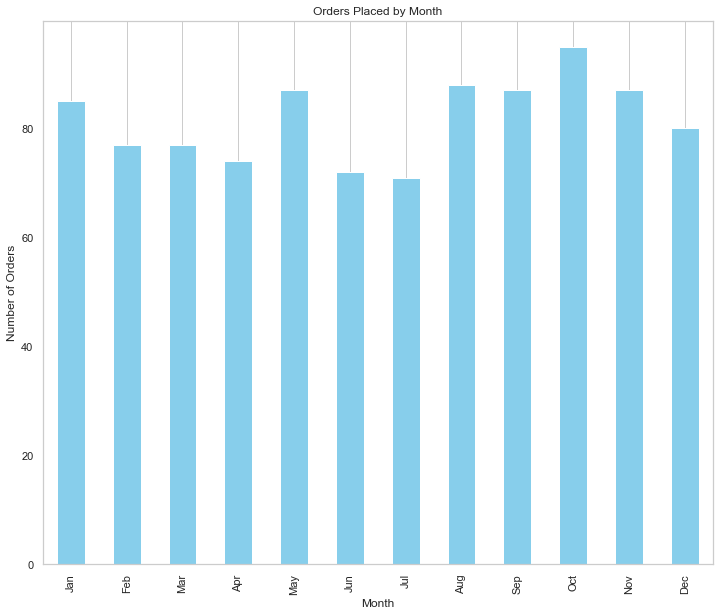

In [89]:
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
monthly_orders.index = [months[i-1] for i in monthly_orders.index]

plt.subplots(figsize=(12,10))

monthly_orders.plot(kind='bar', color='skyblue')
plt.title('Orders Placed by Month')
plt.xlabel('Month')
plt.ylabel('Number of Orders')
plt.grid(axis='y')
plt.show()

## Observations:

1. Order volume is high in months 8-1. Given that the items in this dataset are electronics Thanksgiving, Cyber Monday & Holiday season could be the reason for increase in orders and this might have an impact on "delivery cost".

## Features

## 1. 'is_peak_season' - considering months 8 - 1 in dataset as peak season

In [90]:
# if order placed in months 8 - 1, then peak season
data_df['is_peak_season'] = data_df['date'].dt.month.isin([8, 9, 10, 11, 12, 1]).astype(int)

## 2. Creating features for thanksgiving week & Christmas - New Year week

In [91]:
# Initialize columns with 0 (indicating not peak holiday)
data_df['is_thanksgiving_week'] = 0
data_df['is_christmas_new_year_week'] = 0

# Loop through each year in the dataset
for year in data_df['date'].dt.year.unique():
    thanksgiving = pd.Timestamp(year, 11, 1) + pd.offsets.WeekOfMonth(week=3, weekday=3)  # Fourth Thursday of November
    black_friday = thanksgiving + pd.Timedelta(days=1)
    cyber_monday = thanksgiving + pd.Timedelta(days=4)
    christmas = pd.Timestamp(year, 12, 24)
    new_year = pd.Timestamp(year + 1, 1, 1)
    
    # Mark rows within the holiday ranges
    data_df.loc[(data_df['date'] >= thanksgiving) & (data_df['date'] <= cyber_monday), 'is_thanksgiving_week'] = 1
    data_df.loc[(data_df['date'] >= christmas) & (data_df['date'] < new_year), 'is_christmas_new_year_week'] = 1

## 3.  'is_small_order' - if order_quantity < 4, then 'small'

In [92]:
# Create 'is_small_order' feature, if order size less than 4 then 'small'
data_df['is_small_order'] = data_df['total_quantity'].apply(lambda x: 1 if x < 4 else 0)

## 4. 'Discounted_Order' - If order has discount applied then 1, else 0.

In [93]:
# If coupon_discount is greater than 0, set Discounted_Order as 1, otherwise 0
data_df['is_discounted_Order'] = (data_df['coupon_discount'] > 0).astype(int)

## 5. If delivery distance < 5 kms, then 1 else 0.

In [94]:
# Create 'is_nearby' feature. If less than 5 miles, is_nearby = true
data_df['is_nearby'] = data_df['total_quantity'].apply(lambda x: 1 if x < 5 else 0)

In [95]:
# Convert boolean columns to 1s and 0s
data_df['is_expedited_delivery'] = data_df['is_expedited_delivery'].astype(int)
data_df['is_happy_customer'] = data_df['is_happy_customer'].astype(int)

## Checking the histogram to note the distribution of the columns in dataset

array([[<AxesSubplot:title={'center':'order_price'}>,
        <AxesSubplot:title={'center':'delivery_charges'}>,
        <AxesSubplot:title={'center':'coupon_discount'}>],
       [<AxesSubplot:title={'center':'order_total'}>,
        <AxesSubplot:title={'center':'distance_to_nearest_warehouse'}>,
        <AxesSubplot:title={'center':'is_nearby'}>],
       [<AxesSubplot:title={'center':'is_discounted_Order'}>,
        <AxesSubplot:title={'center':'is_small_order'}>,
        <AxesSubplot:title={'center':'is_peak_season'}>],
       [<AxesSubplot:title={'center':'total_quantity'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

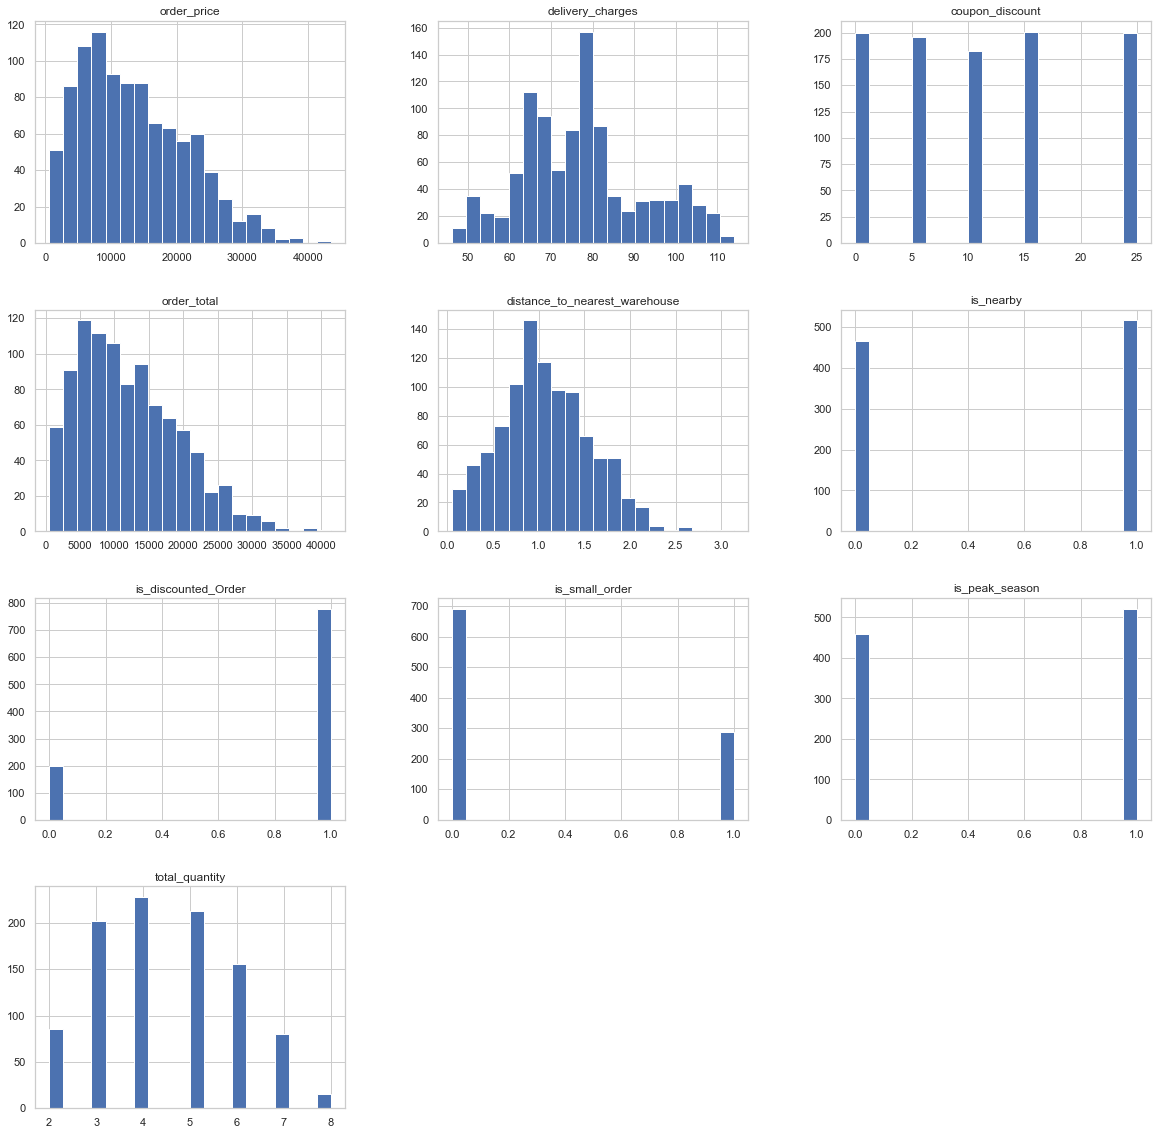

In [96]:

data_df[['order_price','delivery_charges','coupon_discount','order_total','distance_to_nearest_warehouse',
         'is_nearby','is_discounted_Order','is_small_order','is_peak_season','total_quantity']].hist(bins = 20 , figsize= (20,20))

In [97]:
data_df.columns

Index(['order_id', 'customer_id', 'date', 'nearest_warehouse', 'shopping_cart',
       'order_price', 'delivery_charges', 'customer_lat', 'customer_long',
       'coupon_discount', 'order_total', 'season', 'is_expedited_delivery',
       'distance_to_nearest_warehouse', 'latest_customer_review',
       'is_happy_customer', 'month', 'item_names', 'item_quantities',
       'total_quantity', 'is_peak_season', 'is_thanksgiving_week',
       'is_christmas_new_year_week', 'is_small_order', 'is_discounted_Order',
       'is_nearby'],
      dtype='object')

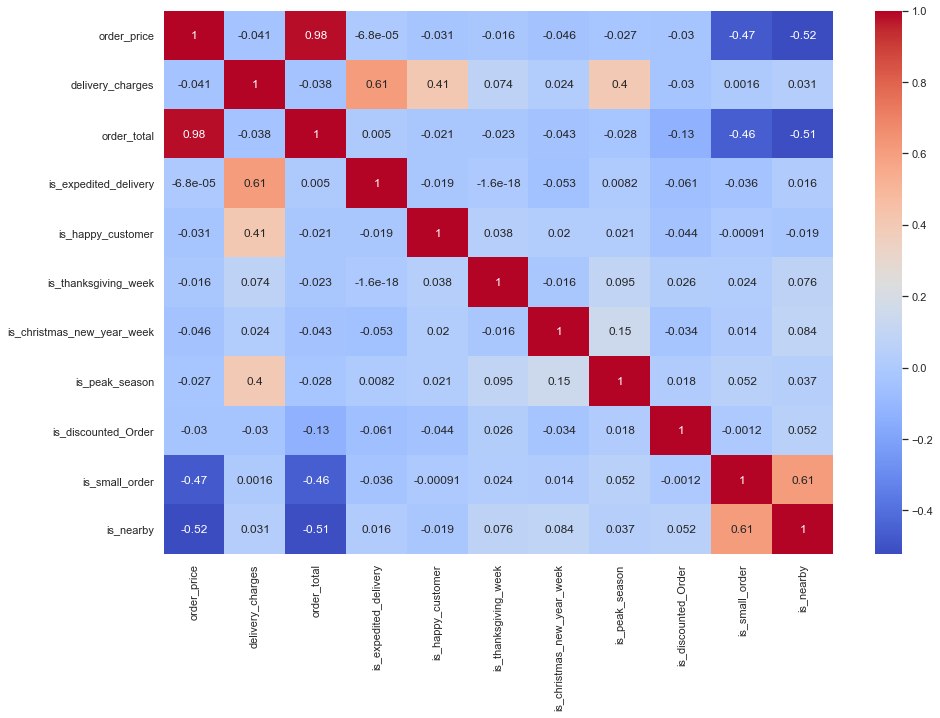

In [98]:
#plotting corr in a heatmap
cor=data_df[['order_price','delivery_charges', 'order_total', 'is_expedited_delivery',
       'is_happy_customer', 'is_thanksgiving_week','is_christmas_new_year_week', 
       'is_peak_season', 'is_discounted_Order', 'is_small_order', 'is_nearby']].corr()

plt.subplots(figsize=(15,10))
sns.heatmap(cor,annot=True, cmap = 'coolwarm')
cor_target = abs(cor["delivery_charges"])

## Creating dummy variables for categorical columns

In [99]:
#using one hot encoder for the categorical column "season"
one_hot_season = pd.get_dummies(data_df.season, drop_first=True)

In [100]:
#dropping the column season and concatenating dummy variable columns to the dataset
data_df.drop(['season'],axis=1,inplace =True)
data_df = pd.concat([data_df, one_hot_season], axis=1)

# E)Estimating deliverycost

## Selecting features for model

In [101]:
model_df = data_df[['delivery_charges', 'is_expedited_delivery', 'is_happy_customer','is_thanksgiving_week', 
                    'is_peak_season', 'is_discounted_Order', 'is_small_order', 'is_nearby','Spring','Summer','Winter']]

In [102]:
model_df.head()

,delivery_charges,is_expedited_delivery,is_happy_customer,is_thanksgiving_week,is_peak_season,is_discounted_Order,is_small_order,is_nearby,Spring,Summer,Winter
0,55.71,0,0,0,1,0,0,0,0,0,1
1,84.86,1,1,0,0,1,0,0,0,0,0
2,63.58,0,1,0,0,1,0,1,0,0,0
3,48.55,0,0,0,0,1,0,0,0,0,0
4,72.41,0,1,0,0,1,1,1,0,1,0


## Using Statsmodels to perform OLS regression to estimate the coefficients

In [103]:
#Removing the target variable and reassigning it to variable y known as target set
X=model_df.drop('delivery_charges',axis=1).values
y=model_df['delivery_charges']

In [104]:
import statsmodels.api as sm

X = sm.add_constant(X)  # Add constant term for intercept
model = sm.OLS(y, X).fit()  # Fit the model

summary = model.summary()
print(summary)

                            OLS Regression Results                            
Dep. Variable:       delivery_charges   R-squared:                       0.866
Model:                            OLS   Adj. R-squared:                  0.864
Method:                 Least Squares   F-statistic:                     623.6
Date:                Mon, 11 Dec 2023   Prob (F-statistic):               0.00
Time:                        12:35:45   Log-Likelihood:                -3029.2
No. Observations:                 980   AIC:                             6080.
Df Residuals:                     969   BIC:                             6134.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         50.4674      0.620     81.336      0.0

From above output, the 'delivery_cost' equation can be written as :

## Delivery Cost = 50.47 + 18.15 X1 + 13.71 X2 − 0.84 X3 + 0.33 X4 + 0.05 X5 + 0.33 X6 − 0.06 X7 + 17.46 X8 + 11.64 X9 − 1.47 X10


where the predictor variables are as follows:

'X1'= is_expedited_delivery ,
'X2'= is_happy_customer ,
'X3'= is_thanksgiving_week ,
'X4'= is_peak_season ,
'X5'= is_discounted_Order ,
'X6'= is_small_order ,
'X7'= is_nearby ,
'X8'= Spring ,
'X9'= Summer ,
'X10'= Winter


## From the model, we can say that these factors affect delivery_cost -


- is_expedited_delivery: Has a significant positive effect on cost. If an order is expedited, it tends to increase delivery cost by 18.15 $.

- is_happy_customer: Has a significant positive effect on cost. A happy customer seems to increase the delivery cost by 13.71 $.

- is_thanksgiving_week: Though the coefficient suggests a decrease in delivery cost by 0.84 $ during Thanksgiving week, the high p-value indicates this is not statistically significant.

- Spring: Has a significant positive effect on cost. If it's Spring, the delivery cost tends to increase by 17.46 $ as compared to autumn.

- Summer: Has a significant positive effect on cost. If it's Summer, the delivery cost tends to increase by 11.64 $ as compared to autumn.

- Winter: Has a decrease in delivery cost by 1.47 $ when it's Winter, and this effect is statistically significant as compared to autumn.


---------------------------

- is_peak_season: The effect on cost is an increase of 0.33 $, but the effect is not statistically significant.

- is_discounted_Order: Minimal positive effect on cost (0.05 $), but not statistically significant.

- is_small_order: Has a small positive effect on cost (0.33 $), but not statistically significant.

- is_nearby: Has a minute negative effect on cost (-0.06 $), but not statistically significant.

## Performing other regression techniques to see if they fit the model better.

## Linear Regression

In [105]:
#creating the formal X and y split
X_train_orig, X_test_orig, y_train, y_test = train_test_split(X,y, test_size = 0.25, random_state=0)

In [106]:
#scaling and transform of X_train and X_test
scaler= MinMaxScaler()  #this scaler helps handle outliers better
scaler.fit(X_train_orig)
X_train= scaler.transform(X_train_orig)
X_test= scaler.transform(X_test_orig)

#Scores
train_score=[]
test_score=[]

In [107]:
# Creating train & test data for linear regression

lreg = LinearRegression()

#Scaled train test
l_model=lreg.fit(X_train, y_train)
train_linear=round(l_model.score(X_train, y_train),2)
test_linear=round(l_model.score(X_test, y_test),2)


print("train_score for Linear Regression:",l_model.score(X_train, y_train))
print("test_score: for Linear Regression", l_model.score(X_test, y_test))

train_score for Linear Regression: 0.8674038772768514
test_score: for Linear Regression 0.8578404629430783


In [108]:
#calculating the accuracies
lg_accuracies = cross_val_score(estimator = l_model, X = X_train, y = y_train, cv = 10)
print("Accuracy: {:.2f} %".format(lg_accuracies.mean()*100))

Accuracy: 86.00 %


## Ridge Regression

In [109]:
#running Ridge Regression on the dataset
np.random.seed(0)
x_range_2 = [0.01, 0.1, 1, 10, 100]
tuned_parameters = [{'alpha':x_range_2}]

#Grid model
ridge = Ridge(max_iter=1000,tol=0.1,random_state=0)
grid_ridge=GridSearchCV(ridge,tuned_parameters,cv=5, return_train_score= True, iid = False)
grid_model_ridge=grid_ridge.fit(X_train,y_train)

print(grid_model_ridge.best_params_)
print('validation score: ', grid_model_ridge.best_score_)

{'alpha': 0.1}
validation score:  0.8612637990874819


In [110]:
#General model based on the alpha condition populated above
ridge_1=Ridge(alpha=0.1)
ridge_model=ridge_1.fit(X_train,y_train)

print("train_score for ridge regression:",ridge_model.score(X_train,y_train))
print("test_score for ridge regression:",ridge_model.score(X_test,y_test))

train_score for ridge regression: 0.8674028103309164
test_score for ridge regression: 0.8578238830421212


In [111]:
#calculating the accuracies
rg_accuracies = cross_val_score(estimator = ridge_model, X = X_train, y = y_train, cv = 10)
print("Accuracy: {:.2f} %".format(rg_accuracies.mean()*100))

Accuracy: 86.00 %


## Lasso regression

In [112]:
#running Lasso Regression on the dataset
np.random.seed(0)    
x_range_3 = [0.01, 0.1, 1, 10, 100, 1000]
tuned_parameters = [{'alpha':x_range_3}]

#Grid model
lasso = Lasso(max_iter=1000,tol=0.1,random_state=0)
grid_lasso=GridSearchCV(lasso,tuned_parameters,cv=5, return_train_score= True, iid = False)
grid_model_lasso=grid_lasso.fit(X_train,y_train)

print(grid_model_lasso.best_params_)
print('validation score: ', grid_model_lasso.best_score_)

{'alpha': 0.01}
validation score:  0.857244596488805


In [113]:
#General model based on the alpha condition populated above
lasso_1=Lasso(alpha=0.01, tol=0.1)
lasso_model=lasso_1.fit(X_train,y_train)
train_score.append(lasso_model.score(X_train,y_train))
test_score.append(lasso_model.score(X_test,y_test))

test=round(lasso_model.score(X_test,y_test),2)

print("train_score for Lasso Regression:",lasso_model.score(X_train,y_train))
print("test_score for Lasso Regression:",lasso_model.score(X_test,y_test))

train_score for Lasso Regression: 0.8631836611774759
test_score for Lasso Regression: 0.8476022848680574


In [114]:
#calculating the accuracies
lasg_accuracies = cross_val_score(estimator = lasso_model, X = X_train, y = y_train, cv = 10)
print("Accuracy: {:.2f} %".format(lasg_accuracies.mean()*100))

Accuracy: 85.66 %


# Comparing the R^2 values, OLS provides the best R^2 value.

------------------------------------------------------------------------------------------------------------------------

## F) Plotting customer latitude and longitude columns

In [115]:
# inspceting visulisation_df
vis_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 980 entries, 0 to 979
Data columns (total 25 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       980 non-null    object        
 1   customer_id                    980 non-null    object        
 2   date                           980 non-null    datetime64[ns]
 3   nearest_warehouse              980 non-null    object        
 4   shopping_cart                  980 non-null    object        
 5   order_price                    980 non-null    float64       
 6   delivery_charges               980 non-null    float64       
 7   customer_lat                   980 non-null    float64       
 8   customer_long                  980 non-null    float64       
 9   coupon_discount                980 non-null    int64         
 10  order_total                    980 non-null    float64       
 11  is_expedited_delive

In [116]:
# creating 2 new df's for viz 
customer_df = vis_df[['customer_id','nearest_warehouse','customer_lat','customer_long']]
warehouse_df = warehouse

In [117]:
# Define a mapping from warehouse name to color
warehouse_colors = {
    'Nickolson': 'red',
    'Thompson': 'green',
    'Bakers': 'blue'
}

# Add colors column
warehouse_df['colors'] = [warehouse_colors[name] for name in warehouse_df['names']]

In [118]:
# drop null 
customer_df.dropna(inplace = True)

In [119]:
def plot_warehouse_customer_map():
    # Create a new map centered around Melbourne
    m = folium.Map(location=[-37.8136, 144.9631], zoom_start=13)

    # Loop through each warehouse
    for idx, warehouse_row in warehouse_df.iterrows():
        # Add warehouse location to the map
        folium.Marker(
            location=[warehouse_row['lat'], warehouse_row['lon']],
            popup=warehouse_row['names'],
            icon=folium.Icon(color=warehouse_row['colors'], icon='building'),
        ).add_to(m)

        # Drawing the circle for the delivery radius
        folium.Circle(
            location=[warehouse_row['lat'], warehouse_row['lon']],
            radius=20000,  # 20 km in meters
            color=warehouse_row['colors'],
            fill=True,
            fill_opacity=0.1
        ).add_to(m)

        # Filter customer data for the specific warehouse
        specific_customers = customer_df[customer_df['nearest_warehouse'] == warehouse_row['names']]
        
        # Plotting customer markers
        for idx, row in specific_customers.iterrows():
            folium.Marker(
                location=[row['customer_lat'], row['customer_long']],
                icon=folium.Icon(color=warehouse_row['colors'], icon='user')
            ).add_to(m)

    # Save the map to an HTML file
    m.save("all_warehouses_map.html")
    return m

# Generate the map with all warehouses and their respective customers
plot_warehouse_customer_map()

## Insights from Map

1. Based on the above graph,  it is clear that majority of the customers who reside in 
 - western melboune are fulfilled by Thompson warehouse (Green)
 - eastern melboune are fulfilled by Bakers warehouse (Blue)
 - central melboune are fulfilled by Nickolson warehouse (Red)
 
But there are some anomalies. We can see a few customers who are in eastern melbourne, fulfilled by other warehouses.

It would be a good strategy to optimize the Warehouse fulfillment process by ensuring the customer orders within a certain radius are fulfilled by the same (nearest) warehouse. 

Optimizing this process by ensuring these customers get their orders fulfilled by blue warehouse will help with:

- reducing driving distance 
- possibility of shipment consolidation 
- faster delivery times

In [120]:
def compute_nearest_warehouse(row):
    distances = {
        'Thompson': row['distance_to_Thompson'],
        'Bakers': row['distance_to_Bakers'],
        'Nickolson': row['distance_to_Nickolson']
    }
    return min(distances, key=distances.get)

cust_dist_df['computed_nearest_warehouse'] = cust_dist_df.apply(compute_nearest_warehouse, axis=1)

In [121]:
result = pd.concat([cust_dist_df, vis_df['nearest_warehouse']], axis=1)

In [122]:
# Identify anomalies where computed_nearest_warehouse does not match nearest_warehouse
anomaly_df = result[result['computed_nearest_warehouse'] != result['nearest_warehouse']]

In [123]:
anomaly_df_cl = anomaly_df.dropna(subset=['computed_nearest_warehouse', 'nearest_warehouse'])

## 1. Customers whose delivery is currently fulfilled by Bakers, but should be fulfilled by other warehouses (computed_nearest_warehouse)

In [124]:
print('No of customers:' + str(len(anomaly_df_cl[anomaly_df_cl['nearest_warehouse']=='Bakers'])))

No of customers:8


In [125]:
anomaly_df_cl[anomaly_df_cl['nearest_warehouse']=='Bakers'][['customer_id','computed_nearest_warehouse','nearest_warehouse']]

,customer_id,computed_nearest_warehouse,nearest_warehouse
10,ID0076459536,Thompson,Bakers
207,ID0266737792,Nickolson,Bakers
213,ID0443297188,Thompson,Bakers
234,ID4294210520,Thompson,Bakers
242,ID0560991981,Thompson,Bakers
295,ID6167231003,Thompson,Bakers
321,ID0702456085,Thompson,Bakers
381,ID6167441063,Nickolson,Bakers


## 2. Customers whose delivery is currently fulfilled by Thompson, but should be fulfilled by other warehouses (computed_nearest_warehouse)

In [126]:
print('No of customers:' + str(len(anomaly_df_cl[anomaly_df_cl['nearest_warehouse']=='Thompson'])))

No of customers:20


In [127]:
anomaly_df_cl[anomaly_df_cl['nearest_warehouse']=='Thompson'][['customer_id','computed_nearest_warehouse','nearest_warehouse']]

,customer_id,computed_nearest_warehouse,nearest_warehouse
77,ID0581715652,Bakers,Thompson
82,ID2776664746,Bakers,Thompson
100,ID4028046142,Bakers,Thompson
128,ID0202736642,Bakers,Thompson
135,ID0248746951,Bakers,Thompson
140,ID0248129431,Bakers,Thompson
145,ID0373641803,Bakers,Thompson
160,ID0253027653,Bakers,Thompson
165,ID6167441029,Bakers,Thompson
170,ID0319157116,Nickolson,Thompson


## 3. Customers whose delivery is currently fulfilled by Nickolson, but should be fulfilled by other warehouses (computed_nearest_warehouse)

In [128]:
print('No of customers:' + str(len(anomaly_df_cl[anomaly_df_cl['nearest_warehouse']=='Nickolson'])))

No of customers:17


In [129]:
anomaly_df_cl[anomaly_df_cl['nearest_warehouse']=='Nickolson'][['customer_id','computed_nearest_warehouse','nearest_warehouse']]

,customer_id,computed_nearest_warehouse,nearest_warehouse
39,ID4418535313,Thompson,Nickolson
49,ID3420939994,Bakers,Nickolson
97,ID2069604238,Bakers,Nickolson
111,ID0493873191,Bakers,Nickolson
114,ID0317535746,Bakers,Nickolson
117,ID0746912592,Bakers,Nickolson
134,ID2318333325,Bakers,Nickolson
141,ID0591320179,Bakers,Nickolson
166,ID6167441023,Thompson,Nickolson
188,ID0277362770,Bakers,Nickolson
